# Tensorflow 101: End-to-end machine learning using Estimators
### Supporting workshop material
By Dora Jambor and Peng Yu



## Outline
In this notebook, we are going to walk through the end-to-end machine learning process using Tensorflow's [Estimators](https://www.tensorflow.org/guide/estimators) API. Estimators simplify machine learning programming by encapsulating the following actions:
training, evaluation, prediction, export for serving. 
This will allow us to focus our efforts on the actual prediction task, the data and the details of our model, rather than on the implementation details of the pipeline.

Our prediction task today will be to classify clothing items into 10 categories. We will go through this process by the following steps:
1. Prepare training and test datasets
2. Choose classifier
3. Encode features
4. Train, Evaluate, Predict
5. Export saved Model

This walkthrough will not go into details on model deployment. For this, please refer to the [Tensorflow Serving](https://www.tensorflow.org/serving/) documentation.

## Prepare training and test datasets
We will work with the new generation of MNIST:  the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). This dataset contains 60K training and 10K images of fashion articles that are categorized into 10 labels. These labels include T-Shirt/top, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag, ankle boot, each mapped to a number from 0 to 9.

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
dataset = input_data.read_data_sets('data/fashion', 
                                    source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')
label_names = ['T-shirt/top', 
               'Trouser', 
               'Pullover', 
               'Dress', 
               'Coat', 
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 26421880 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 29515 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 4422102 bytes.
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 5148 bytes.
Extracting data/fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
print 'Number of training examples: ', dataset.train.num_examples
print 'Number of test examples:     ', dataset.test.num_examples

Number of training examples:  55000
Number of test examples:      10000


## Let's look at some examples

In [5]:
from matplotlib import pyplot as plt

def show_image(idx, dataset=dataset.train):
    """Takes training example index and plots the image."""
    
    plt.imshow(dataset.images[idx].reshape(28, 28))
    print('With label: ', label_names[dataset.labels[idx]])

('With label: ', 'Bag')


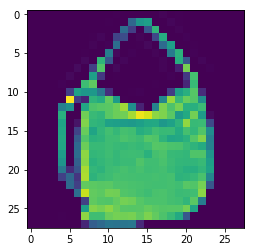

In [6]:
show_image(900)

('With label: ', 'Pullover')


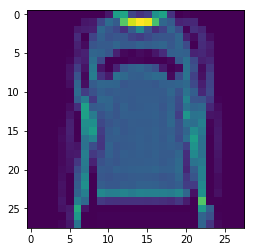

In [7]:
show_image(100)


('With label: ', 'Sneaker')


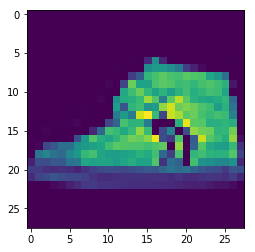

In [8]:
show_image(4004)


## Choose classifier
In this section we will define what our *model_fn* is. This will provide us the interface to do training, evaluation, prediction and exporting. Tensorflow offers two options: **premade estimators** and **custom estimators**. The latter option allows you to define your custom model_fn that best suits your prediction task. To do this, you may find [Tensorflow's mid-level APIs](https://www.tensorflow.org/guide/custom_estimators) useful such as Layers, Datasets, and Metrics.

Premade estimators give you the following default models: a **Deep Neural Network (DNN)** and a **Linear Classifier**. Each model_fn comes with their own hyperparameters. For the purpose of this walkthrough, we won't go into these, but feel free to dig deeper in your own time. Before moving on, can you answer the following questions?

- How does this relate to model_fn we saw earlier?

- What's the purpose of this?

- What criteria would you use to choose the right model?

In [9]:
dnn_classifier = tf.estimator.DNNClassifier
linear_classifier = tf.estimator.LinearClassifier

In [10]:
classifier = linear_classifier

## Encode features
In this step, we will first define our *feature_columns* and then we'll specify our input function that will feed these with our input data.

### 1. Pick feature_columns
Feature engineering is known to be one of the biggest and most time-consuming pain points in the modeling processing to people. The FeatureColumn API makes this process not only way easier, but also encodes the best practices to avoid unnecessary bugs during this process.

The FeatureColumn API provides a simple interface to specify our feature representations. It is as simple as:
- identify our feature types
- find the best representation that suits the chosen model.

In this case, the features are pixels. If you print an example image, you'll see we have a matrix of floats. We even know the dimension of this matrix is 28x28. This is sufficient information for us to know, we will need to choose *numeric_column* as our feature representation.

[Check out their API](https://www.tensorflow.org/guide/feature_columns) to see what other preprocessors this API provides.


In [11]:
feature_columns = [tf.feature_column.numeric_column("pixels", shape=[28, 28])]

###  2. Prepare input function to feed data to estimator
This step involves setting up your input data pipeline. Based on what we saw earlier, this function is required by both the train, evaluate, predict and export_savedmodel methods. The signiture of this function is the following:
- () -> features, labels

In our example, our data is stored in numpy arrays. This makes things easy because Tensorflow already has a built-in input function for numpy types: [tf.estimator.inputs.numpy_input_fn](https://www.tensorflow.org/versions/r1.4/get_started/input_fn).

In general, Tensorflow's Datasets API is there to help you to specify your custom input pipeline. But for the purpose of this walkthrough, we won't go more in depth on this topic.

To see some of the **parameters** this input function takes, refer to the below definitions:

-  [Batch](https://developers.google.com/machine-learning/glossary/#b)

    - The set of examples used in one iteration (that is, one gradient update) of model training.
    

- [Batch size](https://developers.google.com/machine-learning/glossary/#b)

    - The number of examples in a batch. For example, the batch size of SGD is 1, while the batch size of a mini-batch is usually between 10 and 1000. Batch size is usually fixed during training and inference; however, TensorFlow does permit dynamic batch sizes.



- [Epochs](https://developers.google.com/machine-learning/glossary/#e)

    - A full training pass over the entire data set such that each example has been seen once. Thus, an epoch represents N/batch size training iterations, where N is the total number of examples.



- [Steps](https://developers.google.com/machine-learning/glossary/#s)

    - A forward and backward evaluation of one batch.







In [12]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"pixels": dataset.train.images},
    y=dataset.train.labels.astype(tf.int32.as_numpy_dtype),
    num_epochs=None,
    batch_size=50,
    shuffle=True
)

## Train classifier

In [13]:
classifier = tf.estimator.LinearClassifier(feature_columns=feature_columns,
                                           n_classes=10,
                                           model_dir="./tmp/linear_fmnist_model_new",
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12e803ed0>, '_model_dir': './tmp/linear_fmnist_model_new', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}


In [14]:
classifier.train(input_fn=train_input_fn, steps=100)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into ./tmp/linear_fmnist_model_new/model.ckpt.
INFO:tensorflow:loss = 115.129265, step = 1
INFO:tensorflow:Saving checkpoints for 100 into ./tmp/linear_fmnist_model_new/model.ckpt.
INFO:tensorflow:Loss for final step: 82.99433.


## Evaluate classifier
Now that we have a trained model, we would like to evaluate the performance of the trained model by running our classifyer on images that were not seen during training. For this, we will use the test dataset, and follow a similar setup process as for training. First, we will specify the `test_input_fn`, then we will call the `evaluate` method.

In [15]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
 x={"pixels": dataset.test.images},
 y=dataset.test.labels.astype(tf.int32.as_numpy_dtype),
 num_epochs=1,
 shuffle=False
)

In [16]:
metrics = classifier.evaluate(input_fn=test_input_fn)
print("\nTest Accuracy: {0:f}%\n".format(metrics["accuracy"]*100))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-22-17:53:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/linear_fmnist_model_new/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-22-17:53:39
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.6706, average_loss = 2.0839303, global_step = 100, loss = 263.78864
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: ./tmp/linear_fmnist_model_new/model.ckpt-100

Test Accuracy: 67.060000%



## Generate predictions
Congratulations, you've trained a model with 78.65% accuracy! Even though we could most likely achieve higher accuracy than this, for the purpose of this walkthrough, we will move on to generating predictions.

Once we evaluated our model, and have confidence that it is a model that's ready to be used to serve predictions, we can gather a few prediction instances to see what our prediction process would look like. Here we can just use a few example images from the training dataset to validate our output. In real life of course we wouldn't use training images as our prediction instances - there is no need to relabel what's already labeled. Instead, we would want to get predictions on the unlabelled (and not yet seen) images.

Following the earlier signiture, we first set up a `predict_input_fn`, and then feed that into the classifier's `predict` method.

## Select random example to demonstrate prediction process

('With label: ', 'Sneaker')


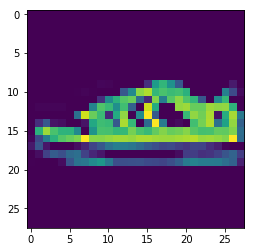

In [17]:
show_image(500)

In [18]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
 x={"pixels": dataset.train.images[500:501]},   ## Take image with index 500
    shuffle=False
)

## We can now see the raw predictions
Notice the schema of the output: you can verify for yourself that the outputted `class_ids`, and `classes` contain the index of the data point that has the highest probability. These `probabilities` correspond to our model's final classification layer's outputs.

In [19]:
predictions = classifier.predict(predict_input_fn)
[i for i in predictions]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/linear_fmnist_model_new/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'class_ids': array([7]),
  'classes': array(['7'], dtype=object),
  'logits': array([ 6.2013183, -1.7537737,  8.533355 ,  9.157687 ,  7.5339594,
         20.260542 ,  3.9681392, 28.720633 , 15.034301 , 13.395748 ],
        dtype=float32),
  'probabilities': array([1.6591810e-10, 5.8215768e-14, 1.7087705e-09, 3.1902729e-09,
         6.2900291e-10, 2.1170778e-04, 1.7784284e-11, 9.9978703e-01,
         1.1376512e-06, 2.2100126e-07], dtype=float32)}]

## With the outputted label index, we can confirm that the label corresponds to the above image.

In [20]:
predictions = classifier.predict(predict_input_fn)
[label_names[i['class_ids'][0]] for i in predictions]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./tmp/linear_fmnist_model_new/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


['Sneaker']

# Export the classifier as SavedModel object
Once we are happy with our model's performance, it is ready to be exported to a specific location either on your local machine (for serving models locally) or to some cloud location (for cloud deployment) using the Estimators' *export_savedmodel* method. For this, please follow these steps:

- Specify model path
- Prepare `serving_input_fn` for export_savedmodel method.

In [21]:
serving_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
                              {"pixels": tf.FixedLenFeature([28, 28], tf.float32)})

In [23]:
model_path = 'my_model/'
model_location = classifier.export_savedmodel(model_path, serving_input_fn)  


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Signatures INCLUDED in export for Classify: ['serving_default', 'classification']
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['predict']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Restoring parameters from ./tmp/linear_fmnist_model_new/model.ckpt-100
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: my_model/temp-1542909301/saved_model.pb


# Deployment and recap
Congratulations, your exported model is now ready for deployment. You can now create a service from your model that takes requests and returns a result. You can run such a service both locally on your machine or deploy it in the cloud.

The SavedModel format works well with [Tensorflow Serving](https://www.tensorflow.org/serving/), a flexible, high-performance system for serving machine learning models in production environments.

Unfortunately, this tutorial won't go into details on how to deploy your models, but if you're interested in the topic, feel free to read up on Tensorflow Serving. If you are using Kubernetes, you might also find [Kubeflow](https://www.kubeflow.org/docs/about/kubeflow/) interesting, it's an open-source project dedicated to making deployments of machine learning (ML) workflows on Kubernetes simple, portable and scalable. 

To recap, we discussed a simple example on building an image classifier using Estimators. Estimators provided us with a flexible API to package up the training, evaluation, prediction and exporting process such that we didn't have to worry about the nitty-gritty details of how these steps are implemented.

If you're keen to try your model "in the wild", I definitely suggest looking into the linked documentations and do the exercise of turning your model into a real service!